# TODO:
- change the name of the *test* method
- create a global function to display an image on an axis, another one to display all the neurons at a given epoch and another one for the evolution of these
- implement cross validation (with log-likelihood)
- check what *pz* is
- error

# Restricted Boltzmann Machine - MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.datasets import fetch_openml
from IPython.display import HTML

In [3]:
class LOGlike(object):
    """
    FORMAT:
    D = 784      # visible
    L = 12       # hidden
    M = len(x)   # number of data points
    a = np.random.uniform(-1, 1, D)
    b = np.random.uniform(-1, 1, L)
    x = np.random.randint(0, 2, (M, D))
    z = np.random.randint(0, 2, L)
    w = np.random.uniform(-1, 1, (D, L))
    """

    def __init__(self, x, L, spins=False):
        self.a = None # a   # visible
        self.b = None # b   # hidden
        self.D = None # a.shape[0]
        self.L = None # b.shape[0]
        self.x = x
        self.spins = spins
        self.M = len(x)
        self.w = None # w
        self.q = None
        self.k = None
        self.esit = []
        self.esit_ix = []
        self.z = None
        #
    #####
    #
    def inizialization(self, a, b, w):
        self.a = a   # visible
        self.b = b   # hidden
        self.D = a.shape[0]
        self.L = b.shape[0]
        self.w = w
        self.make_z_states()
        self.H_and_G()
        #
    #####
    #
    def H_and_G(self):
        
        self.H_z_matrix = np.array([self.H(z) for z in self.z])  # Shape (2^L, D)
        self.G_z_vector = np.array([self.G(z) for z in self.z])  # Shape (2^L,)
        self.k          = np.mean(self.H_z_matrix)
        #
    #####
    #
    def make_z_states(self):
        """
        2^L config
        """
        
        def get_bin(i, L):
            b = bin(i)[2:]
            return ("0" * (L - len(b))) + b
            #
        #####
        #
        self.z = np.array([[int(bit) for bit in get_bin(i, self.L)]
                                       for i in range(2 ** self.L)])
        if self.spins:
            self.z[self.z == 0] = -1
            #
        #####
        #
    #####
    #
    def H(self, z):
        """
        H(z) = a + w @ z
        """
        
        return self.a + np.dot(self.w, z)
        #
    #####
    #
    def G(self, z):
        """
        G(z) = exp(b @ z).
        """
        
        return np.exp(np.dot(self.b, z))
        #
    #####
    #
    def get_numerator(self, x):
        """
        ln{sum_z[G(z) * exp[dot(H_i(z) * x_i)]]}
        """
        
        exp_H_x   = np.exp(self.H_z_matrix @ x - self.k)  # Shape (2^L,)
        numerator = np.sum(self.G_z_vector * exp_H_x)
        
        return self.k + np.log(numerator)
        #
    #####
    #
    def get_denominator(self):
        """
        ln(Z) = D * ln(q) + ln{sum_z[G(z) * prod_i[(1 + H_i(z)) / q]]}
        """

        # q average over 1+exp(H_i(z))
        self.q = 1 + np.exp(np.mean(self.H_z_matrix))

        # sum_Z
        prod_H_q = np.prod((1 + np.exp(self.H_z_matrix)) / self.q, axis = 1)  # Shape (2^L,)
        Z_value  = np.sum(self.G_z_vector * prod_H_q)

        return self.D * np.log(self.q) + np.log(Z_value)
        #
    #####
    #
    def get_denominator_spin(self):
        """
        ln(Z) = D * ln(q) + ln{sum_z[G(z) * prod_i[cosh(H_i(z)) / q]]}
        """

        # q average over cosh(H_i(z))
        self.q = np.cosh(np.mean(self.H_z_matrix))

        # sum_Z
        prod_H_q = np.prod(np.cosh(self.H_z_matrix) / self.q, axis = 1)  # Shape (2^L,)
        Z_value  = np.sum(self.G_z_vector * prod_H_q)

        return self.D * np.log(self.q) + np.log(Z_value)    
        #
    #####
    #
    def run(self):
        """
        l_θ(x) = ln{sum_z[G(z) * exp(H_i(z) * x_i)]} - ln{Z}
        """
        if (self.spins == False):
            lnZ = self.get_denominator()
        else:
            lnZ = self.get_denominator_spin()
            #
        #####
        #
        log_likelihoods = np.array([self.get_numerator(x) - lnZ for x in self.x])
        self.esit.append(np.mean(log_likelihoods))
        #
    #####
    #
    def save(self):
        print(self.esit)
        '''file = open("L/" + str(self.L) + ".txt", "tw")
        file.write(str(self.esit))
        file.close()'''
        #
    #####
    #
#####
#


class RBM:
    def __init__(self, x, L, spins=False, potts=False):
        """
        - x: dataset
        - L: number of hidden units
        - spins: if True sets x_min=-1, else x_min=0
        """
        
        if potts and spins: raise ValueError("Potts and Spins cannot coexist.")
        
        self.x_min = -1 if spins else 0
        self.x_max = 1
        self.x = binarize_data(x, self.x_min, self.x_max)
        self.data_size = len(self.x)
        self.potts = potts
        
        self.D = self.x.shape[1]
        self.L = L
        
        self.params = {
            "w": None,
            "a": None, 
            "b": None
        }
        self.params_history = {
            "w": [], 
            "a": [], 
            "b": []
        }
        
        self.log_likelihood = LOGlike(self.x, self.L, spins=spins)

    def hinton_bias_init(self):
        xmean = np.mean(self.x, axis=0)

        # avoid divergence in log
        delta = 1e-4
        xmean = np.clip(xmean, self.x_min + delta, self.x_max - delta)

        return np.clip(np.log(xmean-self.x_min) - np.log(self.x_max-xmean), -300, 300) 
    
    def initialize_params(self):
        self.params = {
            "w": np.sqrt(4/(self.L + self.D)) * np.random.randn(self.D, self.L),
            "a": self.hinton_bias_init(),
            "b": np.zeros(self.L)
        }
        
        self.params_history = {param: [self.params[param].copy()] for param in self.params.keys()}
    
    def contrastive_divergence(self, vector_input, weights, biases, POTTS=False):
        H = np.clip( np.dot(vector_input, weights) + biases, -300, 300 )
        a = np.exp( (self.x_max - self.x_min) * H )

        output_size = H.shape
        vector_output = np.full(output_size, self.x_min)
        
        if POTTS:
            p = a / np.sum(a) # state probability
            F = np.cumsum(p) # cumulative probability
            r = np.random.rand()
            i = 0
            while r > F[i]:
                i += 1
            vector_output[i] = 1
            
        else:
            p = a / (a + 1) # local probability
            vector_output[np.random.random(output_size) < p] = self.x_max
        
        return vector_output

    def plot_weights_bias(self, weights, biases, cols=0, s=1.5, cmap="bwr", vmin=-4, vmax=4):
        """TODO: upgrade"""
        rows = int(np.ceil( self.L / cols))
        plt.clf()
        fig, axes = plt.subplots(rows, cols, figsize=(s*(1+cols), s*rows))
        for i in range(rows):
            for j in range(cols):
                if cols == 1:
                    ax = axes[i]
                else:
                    ax = axes[i,j]
                if i == j == 0:
                    ax.imshow(biases.reshape((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                    ax.set_title("bias")
                else:
                    ax.imshow(weights.T[i*cols+j-1].reshape((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                    ax.set_title(f"hidden {i*cols+j}")
                ax.set_xticks([])
                ax.set_yticks([])

        plt.subplots_adjust(hspace=.3)
        plt.show()
        plt.close()

    def training(self, optimizer="RMSprop", epochs=150, batches=20, batch_i=10, batch_f=500, 
                 lr=0.05, epsilon=1e-4, cd_steps=2, gamma=0.001, details=False):
        
        if optimizer == "SGD":
            lr_i, lr_f = 1., 0.25
        elif optimizer == "RMSprop":
            lr_i = lr_f = lr
            beta, epsilon = 0.9, epsilon
        else:
            raise ValueError("Optimizer should either be SGD or RMSprop.")
        
        s = {param:np.zeros_like(self.params[param]) for param in ["w", "a", "b"]}
        list_indices = np.arange(self.x.shape[0])
        
        for epoch in range(1, epochs+1):
            q = (epoch - 1) / (epochs - 1)
            batch_size = int(batch_i + (batch_f-batch_i) * q**2)
            lr = lr_i + (lr_f-lr_i) * q
            
            for _ in range(batches):
                v_data, v_model = [np.zeros(self.D) for _ in range(2)]
                h_data, h_model = [np.zeros(self.L) for _ in range(2)]
                vh_data, vh_model = [np.zeros((self.D,self.L)) for _ in range(2)]
                
                selected_indices = np.random.choice(list_indices, batch_size, replace=False)
                for i in range(batch_size):
                    # positive CD phase
                    v = self.x[selected_indices[i]]
                    h = self.contrastive_divergence(v, self.params["w"], self.params["b"], POTTS=self.potts)
                    
                    v_data += v
                    h_data += h
                    vh_data += np.outer(v, h)
                    
                    # generate fantasy data
                    hf = h.copy()
                    for _ in range(cd_steps):
                        # negative CD phase
                        vf = self.contrastive_divergence(hf, self.params["w"].T, self.params["a"])
                        # positive CD phase
                        hf = self.contrastive_divergence(vf, self.params["w"], self.params["b"], POTTS=self.potts)

                    v_model += vf
                    h_model += hf
                    vh_model += np.outer(vf, hf)
                    
                # gradient of likelihood
                data_models = {
                    "w": (vh_data,vh_model),
                    "a": (v_data,v_model),
                    "b": (h_data,h_model)
                }
                for param,(d,m) in data_models.items():            
                    grad_theta = (d - m) / batch_size
                    
                    if optimizer == "RMSprop":
                        s[param] = beta * s[param] + (1-beta) * grad_theta**2
                        new_param = lr * grad_theta / np.sqrt(epsilon + s[param])
                    else:
                        new_param = lr * grad_theta

                    self.params[param] += new_param

                    if gamma > 0:
                        self.params[param] -= (gamma * lr) * np.sign(self.params[param])
            
            # save weights and biases for every epoch
            for param in ["w", "a", "b"]:
                self.params_history[param].append(self.params[param].copy())
            
            # plot training process
            if details:
                print(f"Epoch: {epoch} / {epochs}")
                if epoch % 20 == 0:
                    self.plot_weights_bias(self.params["w"], self.params["a"], cols=self.L//2)
    
    def weights_bias_evolution(self, interval=200, cols=0, s=1.5, cmap="bwr", vmin=-4, vmax=4):        
        rows = int(np.ceil( self.L / cols))
        
        fig, axes = plt.subplots(rows, cols, figsize=(s*(1+cols), s*rows))
        plt.subplots_adjust(hspace=0.3)
        
        images = []
        for i in range(rows):
            row_images = []
            for j in range(cols):
                if cols == 1:
                    ax = axes[i]
                else:
                    ax = axes[i,j]
                img = ax.imshow(np.zeros((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                row_images.append(img)
                ax.set_xticks([])
                ax.set_yticks([])
            images.append(row_images)
            
        def animate(epoch):
            weights = self.params_history["w"][epoch]
            biases = self.params_history["a"][epoch]
            
            for i in range(rows):
                for j in range(cols):
                    if cols == 1:
                        ax = axes[i]
                    else:
                        ax = axes[i,j]
                    
                    if i == j == 0:
                        images[i][j].set_data(biases.reshape((28,28)))
                        ax.set_title(f"bias")
                    else:
                        images[i][j].set_data(weights.T[i*cols+j-1].reshape((28,28)))
                        ax.set_title(f"hidden {i*cols+j}")
            plt.title(f"Epoch {epoch}")
            return [img for row in images for img in row]

        self.ani = FuncAnimation(fig, animate, repeat=True, frames=len(self.params_history["w"]), interval=interval)
        return HTML(self.ani.to_jshtml())
    
    def test(self, v_test, n=200, af=1):
        v = v_test.copy()
        v_history = []
        h_history = []
        for _ in range(n):
            h = self.contrastive_divergence(v, self.params["w"], self.params["b"], POTTS=self.potts)
            v = self.contrastive_divergence(h, af*self.params["w"].T, af*self.params["a"])
            v_history.append(v)
            h_history.append(h)
        
        return v_history, h_history

    def likelihood_history(self, n=5):
        self.log_likelihood.esit = []
        if n == 1:
            list_ix = [-1]
        else:
            list_ix = np.linspace(0, len(self.params_history["w"])-1, n, dtype=int)
        self.log_likelihood.esit_ix = list_ix.copy()
        
        for ix in list_ix:
            self.log_likelihood.inizialization(
                self.params_history["a"][ix], self.params_history["b"][ix], self.params_history["w"][ix]
            )
            self.log_likelihood.run()
        
    def cross_validation(self):
        pass

def binarize_data(data, x_min=0, x_max=1):
    return np.where(data/255 > 0.5, x_max, x_min)

In [3]:
# all handwritten numbers from 0 to 9
X, Y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# numbers to keep
list_numbers = [str(i) for i in range(10)][:3]
index_to_keep = np.isin(Y, list_numbers)
X_keep = X[index_to_keep]
Y_keep = Y[index_to_keep]

## 2.a

In [4]:
rbm = RBM(X_keep, 3, spins=False, potts=False)
rbm.initialize_params()
rbm.training(epochs=150, optimizer="RMSprop")
rbm.likelihood_history(6)

Epoch: 1 / 150
Epoch: 2 / 150
Epoch: 3 / 150
Epoch: 4 / 150
Epoch: 5 / 150
Epoch: 6 / 150
Epoch: 7 / 150
Epoch: 8 / 150
Epoch: 9 / 150
Epoch: 10 / 150
Epoch: 11 / 150
Epoch: 12 / 150
Epoch: 13 / 150
Epoch: 14 / 150
Epoch: 15 / 150
Epoch: 16 / 150
Epoch: 17 / 150
Epoch: 18 / 150
Epoch: 19 / 150
Epoch: 20 / 150
Epoch: 21 / 150
Epoch: 22 / 150
Epoch: 23 / 150
Epoch: 24 / 150
Epoch: 25 / 150
Epoch: 26 / 150
Epoch: 27 / 150
Epoch: 28 / 150
Epoch: 29 / 150
Epoch: 30 / 150
Epoch: 31 / 150
Epoch: 32 / 150
Epoch: 33 / 150
Epoch: 34 / 150
Epoch: 35 / 150
Epoch: 36 / 150
Epoch: 37 / 150
Epoch: 38 / 150
Epoch: 39 / 150
Epoch: 40 / 150
Epoch: 41 / 150
Epoch: 42 / 150
Epoch: 43 / 150
Epoch: 44 / 150
Epoch: 45 / 150
Epoch: 46 / 150
Epoch: 47 / 150
Epoch: 48 / 150
Epoch: 49 / 150
Epoch: 50 / 150
Epoch: 51 / 150
Epoch: 52 / 150
Epoch: 53 / 150
Epoch: 54 / 150
Epoch: 55 / 150
Epoch: 56 / 150
Epoch: 57 / 150
Epoch: 58 / 150
Epoch: 59 / 150
Epoch: 60 / 150
Epoch: 61 / 150
Epoch: 62 / 150
Epoch: 63 / 150
E

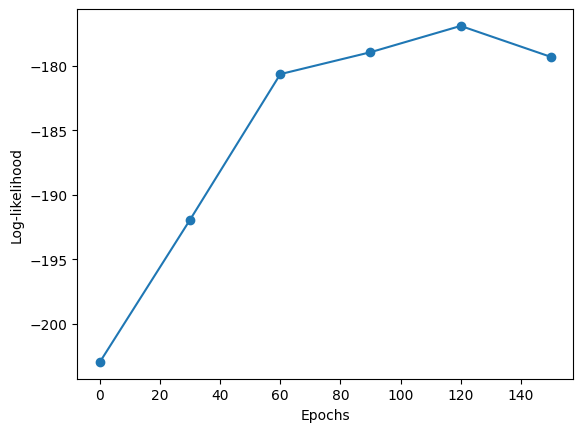

In [5]:
list_e = rbm.log_likelihood.esit_ix
list_l = rbm.log_likelihood.esit

plt.plot(list_e, list_l, "o-")
plt.xlabel("Epochs")
plt.ylabel("Log-likelihood")
plt.show()

## 2.b

In [6]:
rbm = RBM(X_keep, 3, spins=False, potts=False)
list_l = []
for i in range(1,4):
    print(f"CD_steps: {i}")
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", cd_steps=i)
    rbm.likelihood_history(6)
    list_l.append( rbm.log_likelihood.esit )

list_e = rbm.log_likelihood.esit_ix

CD_steps: 1
Epoch: 1 / 150
Epoch: 2 / 150
Epoch: 3 / 150
Epoch: 4 / 150
Epoch: 5 / 150
Epoch: 6 / 150
Epoch: 7 / 150
Epoch: 8 / 150
Epoch: 9 / 150
Epoch: 10 / 150
Epoch: 11 / 150
Epoch: 12 / 150
Epoch: 13 / 150
Epoch: 14 / 150
Epoch: 15 / 150
Epoch: 16 / 150
Epoch: 17 / 150
Epoch: 18 / 150
Epoch: 19 / 150
Epoch: 20 / 150
Epoch: 21 / 150
Epoch: 22 / 150
Epoch: 23 / 150
Epoch: 24 / 150
Epoch: 25 / 150
Epoch: 26 / 150
Epoch: 27 / 150
Epoch: 28 / 150
Epoch: 29 / 150
Epoch: 30 / 150
Epoch: 31 / 150
Epoch: 32 / 150
Epoch: 33 / 150
Epoch: 34 / 150
Epoch: 35 / 150
Epoch: 36 / 150
Epoch: 37 / 150
Epoch: 38 / 150
Epoch: 39 / 150
Epoch: 40 / 150
Epoch: 41 / 150
Epoch: 42 / 150
Epoch: 43 / 150
Epoch: 44 / 150
Epoch: 45 / 150
Epoch: 46 / 150
Epoch: 47 / 150
Epoch: 48 / 150
Epoch: 49 / 150
Epoch: 50 / 150
Epoch: 51 / 150
Epoch: 52 / 150
Epoch: 53 / 150
Epoch: 54 / 150
Epoch: 55 / 150
Epoch: 56 / 150
Epoch: 57 / 150
Epoch: 58 / 150
Epoch: 59 / 150
Epoch: 60 / 150
Epoch: 61 / 150
Epoch: 62 / 150
Epoch

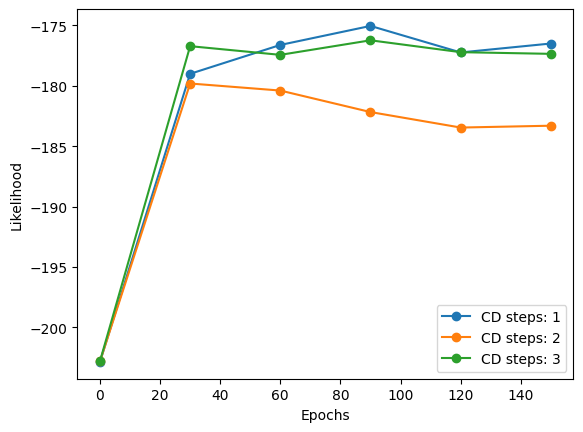

In [7]:
for i,likelihoods in enumerate(list_l):
    plt.plot(list_e, likelihoods, "o-", label=f"CD steps: {i+1}")
plt.legend()
# plt.grid(linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Likelihood")
plt.show()

## 2.c

In [8]:
list_L = list(range(3,11))
list_likelihoods = []
for L in list_L:
    print(f"L: {L}")
    rbm = RBM(X_keep, L, spins=False, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop")
    rbm.likelihood_history(1)
    list_likelihoods.append( rbm.log_likelihood.esit[0] )

L: 3
Epoch: 1 / 150
Epoch: 2 / 150
Epoch: 3 / 150
Epoch: 4 / 150
Epoch: 5 / 150
Epoch: 6 / 150
Epoch: 7 / 150
Epoch: 8 / 150
Epoch: 9 / 150
Epoch: 10 / 150
Epoch: 11 / 150
Epoch: 12 / 150
Epoch: 13 / 150
Epoch: 14 / 150
Epoch: 15 / 150
Epoch: 16 / 150
Epoch: 17 / 150
Epoch: 18 / 150
Epoch: 19 / 150
Epoch: 20 / 150
Epoch: 21 / 150
Epoch: 22 / 150
Epoch: 23 / 150
Epoch: 24 / 150
Epoch: 25 / 150
Epoch: 26 / 150
Epoch: 27 / 150
Epoch: 28 / 150
Epoch: 29 / 150
Epoch: 30 / 150
Epoch: 31 / 150
Epoch: 32 / 150
Epoch: 33 / 150
Epoch: 34 / 150
Epoch: 35 / 150
Epoch: 36 / 150
Epoch: 37 / 150
Epoch: 38 / 150
Epoch: 39 / 150
Epoch: 40 / 150
Epoch: 41 / 150
Epoch: 42 / 150
Epoch: 43 / 150
Epoch: 44 / 150
Epoch: 45 / 150
Epoch: 46 / 150
Epoch: 47 / 150
Epoch: 48 / 150
Epoch: 49 / 150
Epoch: 50 / 150
Epoch: 51 / 150
Epoch: 52 / 150
Epoch: 53 / 150
Epoch: 54 / 150
Epoch: 55 / 150
Epoch: 56 / 150
Epoch: 57 / 150
Epoch: 58 / 150
Epoch: 59 / 150
Epoch: 60 / 150
Epoch: 61 / 150
Epoch: 62 / 150
Epoch: 63 / 

Epoch: 55 / 150
Epoch: 56 / 150
Epoch: 57 / 150
Epoch: 58 / 150
Epoch: 59 / 150
Epoch: 60 / 150
Epoch: 61 / 150
Epoch: 62 / 150
Epoch: 63 / 150
Epoch: 64 / 150
Epoch: 65 / 150
Epoch: 66 / 150
Epoch: 67 / 150
Epoch: 68 / 150
Epoch: 69 / 150
Epoch: 70 / 150
Epoch: 71 / 150
Epoch: 72 / 150
Epoch: 73 / 150
Epoch: 74 / 150
Epoch: 75 / 150
Epoch: 76 / 150
Epoch: 77 / 150
Epoch: 78 / 150
Epoch: 79 / 150
Epoch: 80 / 150
Epoch: 81 / 150
Epoch: 82 / 150
Epoch: 83 / 150
Epoch: 84 / 150
Epoch: 85 / 150
Epoch: 86 / 150
Epoch: 87 / 150
Epoch: 88 / 150
Epoch: 89 / 150
Epoch: 90 / 150
Epoch: 91 / 150
Epoch: 92 / 150
Epoch: 93 / 150
Epoch: 94 / 150
Epoch: 95 / 150
Epoch: 96 / 150
Epoch: 97 / 150
Epoch: 98 / 150
Epoch: 99 / 150
Epoch: 100 / 150
Epoch: 101 / 150
Epoch: 102 / 150
Epoch: 103 / 150
Epoch: 104 / 150
Epoch: 105 / 150
Epoch: 106 / 150
Epoch: 107 / 150
Epoch: 108 / 150
Epoch: 109 / 150
Epoch: 110 / 150
Epoch: 111 / 150
Epoch: 112 / 150
Epoch: 113 / 150
Epoch: 114 / 150
Epoch: 115 / 150
Epoch: 1

Epoch: 108 / 150
Epoch: 109 / 150
Epoch: 110 / 150
Epoch: 111 / 150
Epoch: 112 / 150
Epoch: 113 / 150
Epoch: 114 / 150
Epoch: 115 / 150
Epoch: 116 / 150
Epoch: 117 / 150
Epoch: 118 / 150
Epoch: 119 / 150
Epoch: 120 / 150
Epoch: 121 / 150
Epoch: 122 / 150
Epoch: 123 / 150
Epoch: 124 / 150
Epoch: 125 / 150
Epoch: 126 / 150
Epoch: 127 / 150
Epoch: 128 / 150
Epoch: 129 / 150
Epoch: 130 / 150
Epoch: 131 / 150
Epoch: 132 / 150
Epoch: 133 / 150
Epoch: 134 / 150
Epoch: 135 / 150
Epoch: 136 / 150
Epoch: 137 / 150
Epoch: 138 / 150
Epoch: 139 / 150
Epoch: 140 / 150
Epoch: 141 / 150
Epoch: 142 / 150
Epoch: 143 / 150
Epoch: 144 / 150
Epoch: 145 / 150
Epoch: 146 / 150
Epoch: 147 / 150
Epoch: 148 / 150
Epoch: 149 / 150
Epoch: 150 / 150
L: 10
Epoch: 1 / 150
Epoch: 2 / 150
Epoch: 3 / 150
Epoch: 4 / 150
Epoch: 5 / 150
Epoch: 6 / 150
Epoch: 7 / 150
Epoch: 8 / 150
Epoch: 9 / 150
Epoch: 10 / 150
Epoch: 11 / 150
Epoch: 12 / 150
Epoch: 13 / 150
Epoch: 14 / 150
Epoch: 15 / 150
Epoch: 16 / 150
Epoch: 17 / 150


Epoch: 10 / 150
Epoch: 11 / 150
Epoch: 12 / 150
Epoch: 13 / 150
Epoch: 14 / 150
Epoch: 15 / 150
Epoch: 16 / 150
Epoch: 17 / 150
Epoch: 18 / 150
Epoch: 19 / 150
Epoch: 20 / 150
Epoch: 21 / 150
Epoch: 22 / 150
Epoch: 23 / 150
Epoch: 24 / 150
Epoch: 25 / 150
Epoch: 26 / 150
Epoch: 27 / 150
Epoch: 28 / 150
Epoch: 29 / 150
Epoch: 30 / 150
Epoch: 31 / 150
Epoch: 32 / 150
Epoch: 33 / 150
Epoch: 34 / 150
Epoch: 35 / 150
Epoch: 36 / 150
Epoch: 37 / 150
Epoch: 38 / 150
Epoch: 39 / 150
Epoch: 40 / 150
Epoch: 41 / 150
Epoch: 42 / 150
Epoch: 43 / 150
Epoch: 44 / 150
Epoch: 45 / 150
Epoch: 46 / 150
Epoch: 47 / 150
Epoch: 48 / 150
Epoch: 49 / 150
Epoch: 50 / 150
Epoch: 51 / 150
Epoch: 52 / 150
Epoch: 53 / 150
Epoch: 54 / 150
Epoch: 55 / 150
Epoch: 56 / 150
Epoch: 57 / 150
Epoch: 58 / 150
Epoch: 59 / 150
Epoch: 60 / 150
Epoch: 61 / 150
Epoch: 62 / 150
Epoch: 63 / 150
Epoch: 64 / 150
Epoch: 65 / 150
Epoch: 66 / 150
Epoch: 67 / 150
Epoch: 68 / 150
Epoch: 69 / 150
Epoch: 70 / 150
Epoch: 71 / 150
Epoch: 7

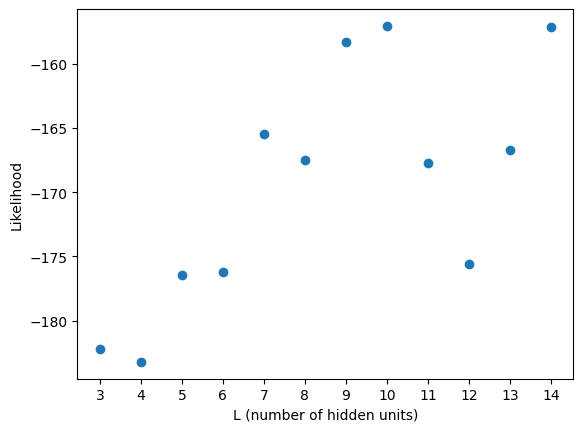

In [9]:
plt.scatter(list_L, list_likelihoods)
# plt.grid(linestyle="--")
plt.xticks(list_L)
plt.xlabel("L (number of hidden units)")
plt.ylabel("Likelihood")
plt.show()

# 3
To change:
- gradient descent
    - type: RMSprop, SGD
    - parameters: leraning rate, epsilon
- spins=True/False
- potts=True/False
- regularization
- ...

## 3.a

Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

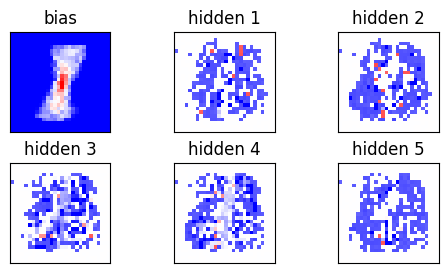

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

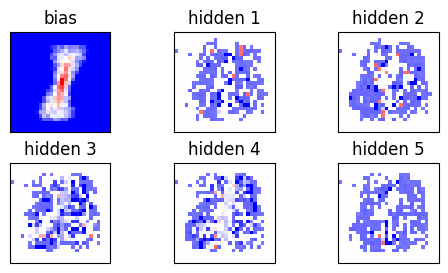

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

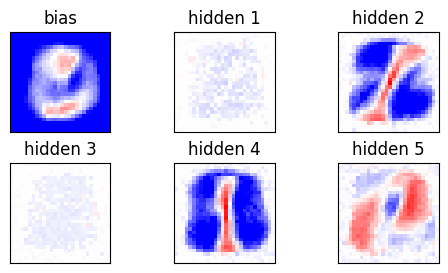

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

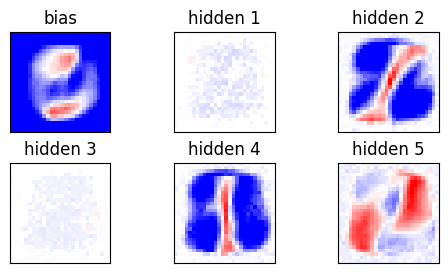

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

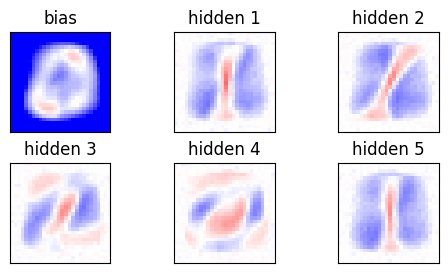

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

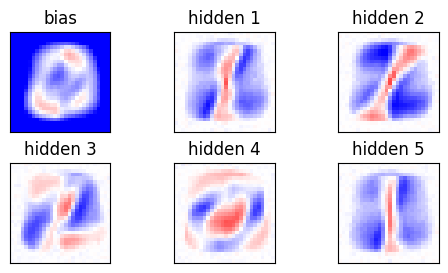

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

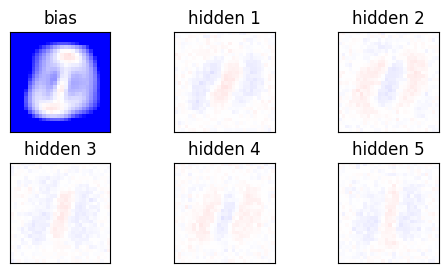

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

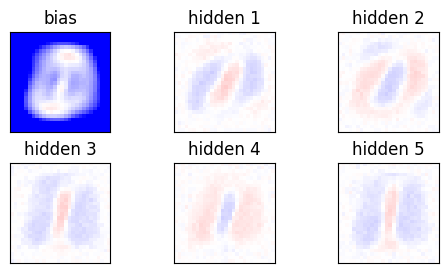

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

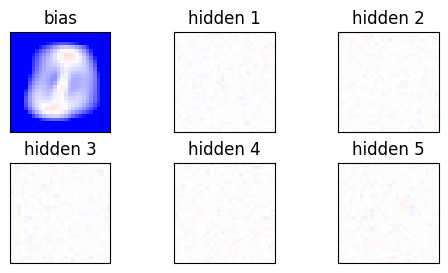

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

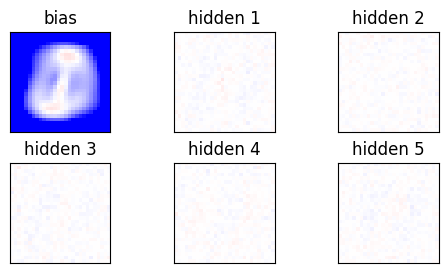

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50


In [30]:
list_l_tot = []
for n in range(0,-5,-1):
    rbm = RBM(X_keep, 6, spins=False, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=50, optimizer="RMSprop", lr=10**n, details=True)
    rbm.likelihood_history(6)
    
    list_l_tot.append(rbm.log_likelihood.esit)
    
list_e = rbm.log_likelihood.esit_ix

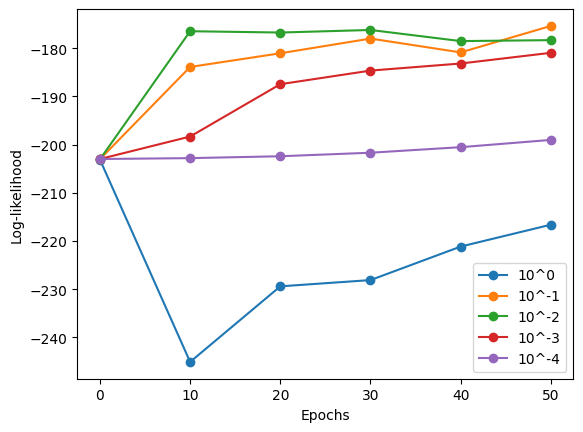

In [31]:
ns = list(range(0,-5,-1))
for i,list_l in enumerate(list_l_tot):
    plt.plot(list_e, list_l, "o-", label=f"learning rate = 10^{ns[i]}")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log-likelihood")
plt.show()

Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

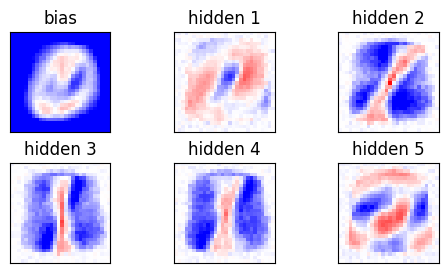

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

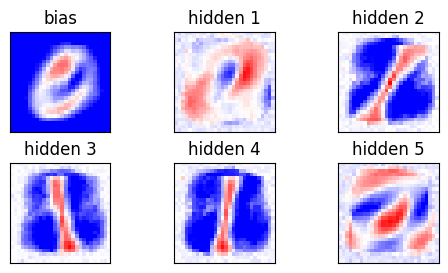

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

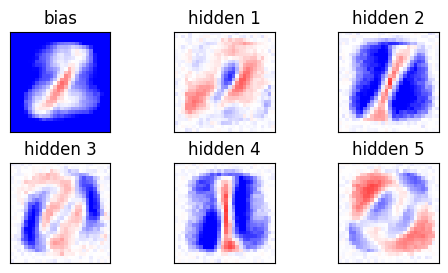

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

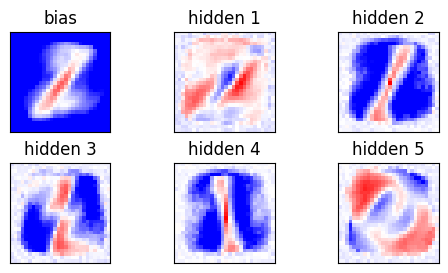

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

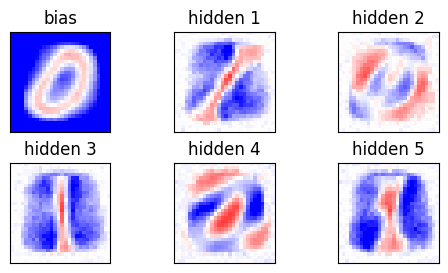

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

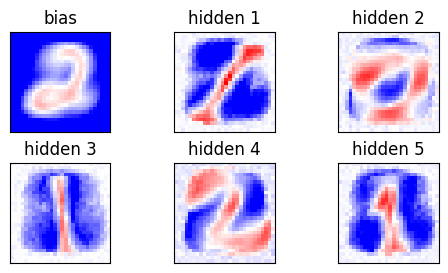

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

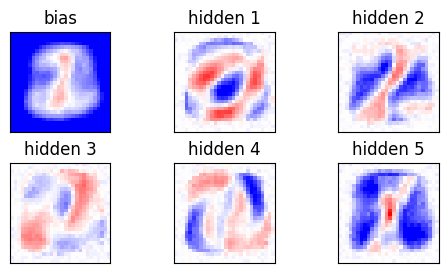

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

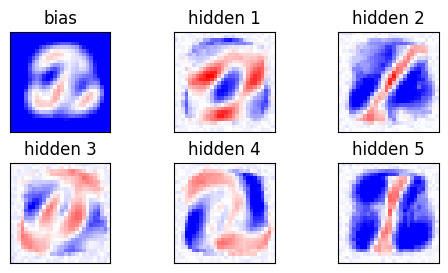

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

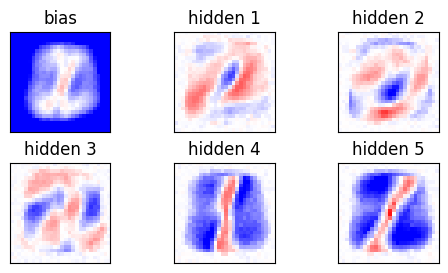

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

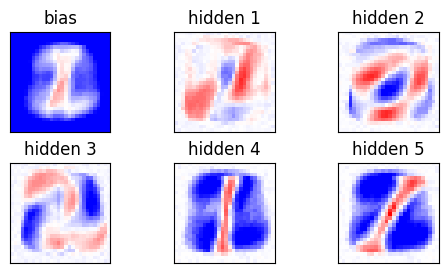

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50


In [33]:
list_l_tot = []
for n in range(-9,-3):
    rbm = RBM(X_keep, 6, spins=False, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=50, optimizer="RMSprop", epsilon=10**n, details=True)
    rbm.likelihood_history(6)
    
    list_l_tot.append(rbm.log_likelihood.esit)
    
list_e = rbm.log_likelihood.esit_ix

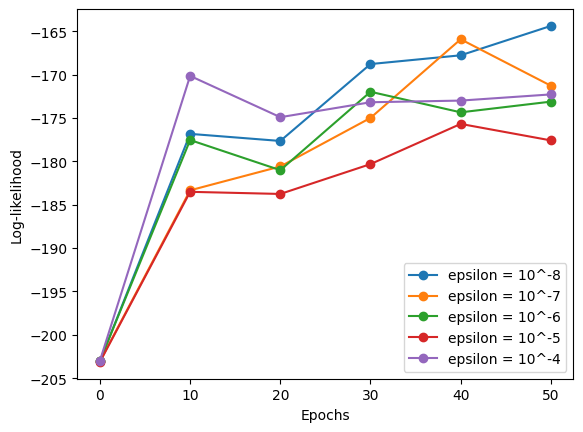

In [34]:
ns = list(range(-9,-3))
for i,list_l in enumerate(list_l_tot):
    plt.plot(list_e, list_l, "o-", label=f"epsilon = 10^{ns[i]}")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log-likelihood")
plt.show()

In [35]:
L = 10
epochs = 150
n_likelihoods = 6

rbm_sgd = RBM(X_keep, L)
rbm_sgd.initialize_params()
rbm_sgd.training(epochs=epochs, optimizer="SGD")
rbm_sgd.likelihood_history(n_likelihoods)

rbm_rms = RBM(X_keep, L)
rbm_rms.initialize_params()
rbm_rms.training(epochs=epochs, optimizer="RMSprop", epsilon=1e-8)
rbm_rms.likelihood_history(n_likelihoods)

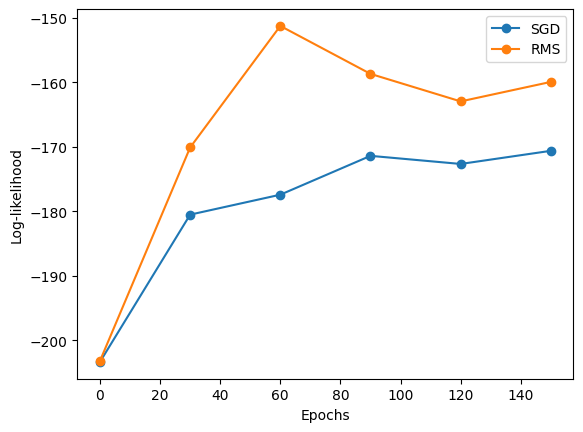

In [39]:
list_e = rbm_sgd.log_likelihood.esit_ix
list_l_sgd = rbm_sgd.log_likelihood.esit
list_l_rms = rbm_rms.log_likelihood.esit

plt.plot(list_e, list_l_sgd, "o-", label="SGD")
plt.plot(list_e, list_l_rms, "o-", label="RMS")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log-likelihood")
plt.show()

Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

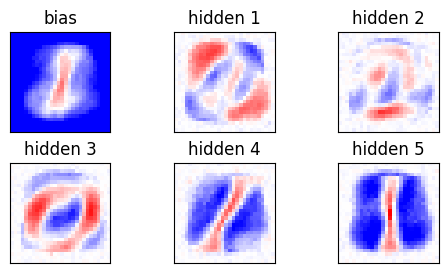

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

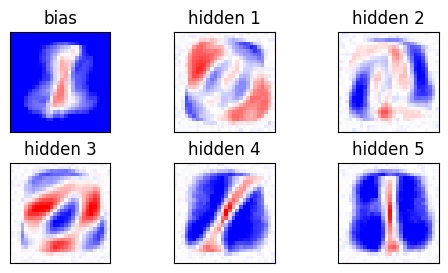

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

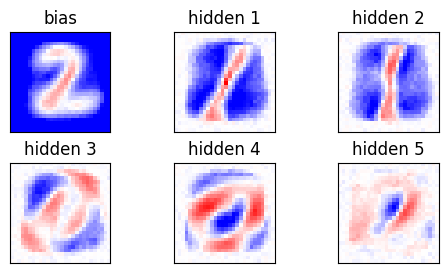

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

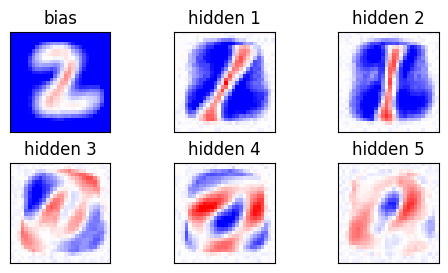

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

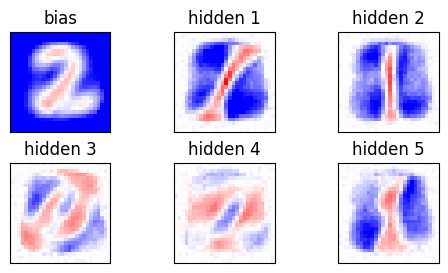

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

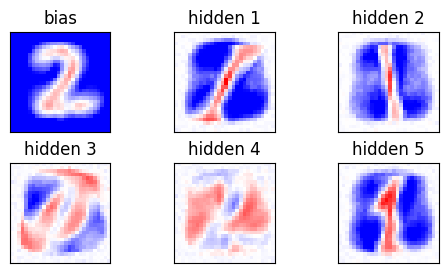

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

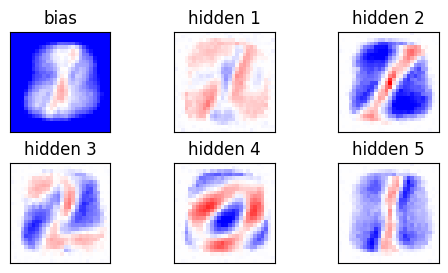

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

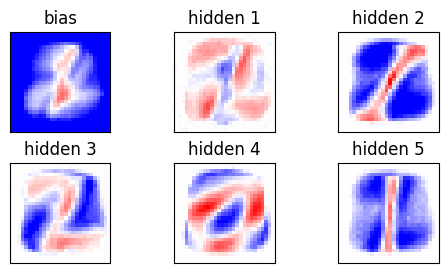

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

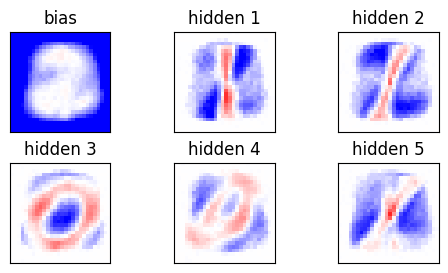

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

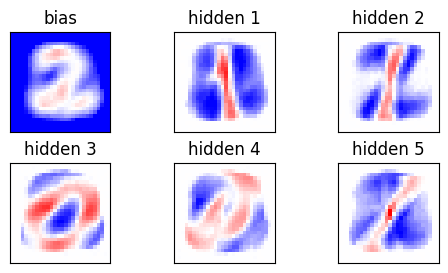

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50
Epoch: 1 / 50
Epoch: 2 / 50
Epoch: 3 / 50
Epoch: 4 / 50
Epoch: 5 / 50
Epoch: 6 / 50
Epoch: 7 / 50
Epoch: 8 / 50
Epoch: 9 / 50
Epoch: 10 / 50
Epoch: 11 / 50
Epoch: 12 / 50
Epoch: 13 / 50
Epoch: 14 / 50
Epoch: 15 / 50
Epoch: 16 / 50
Epoch: 17 / 50
Epoch: 18 / 50
Epoch: 19 / 50
Epoch: 20 / 50


<Figure size 640x480 with 0 Axes>

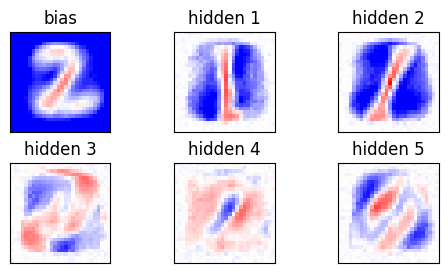

Epoch: 21 / 50
Epoch: 22 / 50
Epoch: 23 / 50
Epoch: 24 / 50
Epoch: 25 / 50
Epoch: 26 / 50
Epoch: 27 / 50
Epoch: 28 / 50
Epoch: 29 / 50
Epoch: 30 / 50
Epoch: 31 / 50
Epoch: 32 / 50
Epoch: 33 / 50
Epoch: 34 / 50
Epoch: 35 / 50
Epoch: 36 / 50
Epoch: 37 / 50
Epoch: 38 / 50
Epoch: 39 / 50
Epoch: 40 / 50


<Figure size 640x480 with 0 Axes>

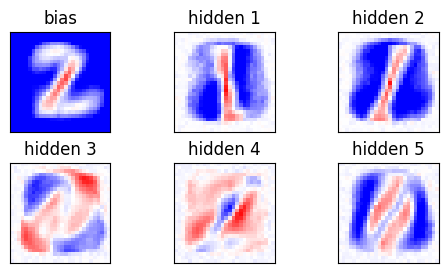

Epoch: 41 / 50
Epoch: 42 / 50
Epoch: 43 / 50
Epoch: 44 / 50
Epoch: 45 / 50
Epoch: 46 / 50
Epoch: 47 / 50
Epoch: 48 / 50
Epoch: 49 / 50
Epoch: 50 / 50


In [45]:
list_l_tot = []
gamma_values = [f"10**{n}" if n != 0 else "0" for n in range(-5,1)]
for gamma in gamma_values:
    rbm = RBM(X_keep, 6)
    rbm.initialize_params()
    rbm.training(epochs=50, optimizer="RMSprop", gamma=eval(gamma), details=True)
    rbm.likelihood_history(6)
    
    list_l_tot.append(rbm.log_likelihood.esit)
    
list_e = rbm.log_likelihood.esit_ix

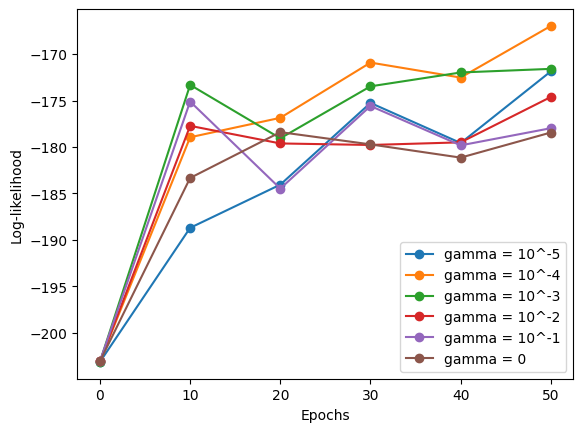

In [46]:
for i,list_l in enumerate(list_l_tot):
    plt.plot(list_e, list_l, "o-", label="gamma = " + gamma_values[i].replace("**", "^"))
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log-likelihood")
plt.show()

Bernoulli
Epoch: 1 / 150
Epoch: 2 / 150
Epoch: 3 / 150
Epoch: 4 / 150
Epoch: 5 / 150
Epoch: 6 / 150
Epoch: 7 / 150
Epoch: 8 / 150
Epoch: 9 / 150
Epoch: 10 / 150
Epoch: 11 / 150
Epoch: 12 / 150
Epoch: 13 / 150
Epoch: 14 / 150
Epoch: 15 / 150
Epoch: 16 / 150
Epoch: 17 / 150
Epoch: 18 / 150
Epoch: 19 / 150
Epoch: 20 / 150


<Figure size 640x480 with 0 Axes>

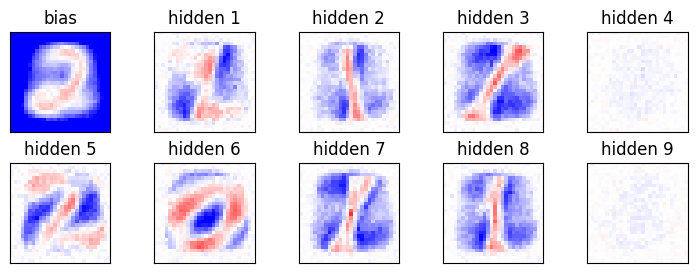

Epoch: 21 / 150
Epoch: 22 / 150
Epoch: 23 / 150
Epoch: 24 / 150
Epoch: 25 / 150
Epoch: 26 / 150
Epoch: 27 / 150
Epoch: 28 / 150
Epoch: 29 / 150
Epoch: 30 / 150
Epoch: 31 / 150
Epoch: 32 / 150
Epoch: 33 / 150
Epoch: 34 / 150
Epoch: 35 / 150
Epoch: 36 / 150
Epoch: 37 / 150
Epoch: 38 / 150
Epoch: 39 / 150
Epoch: 40 / 150


<Figure size 640x480 with 0 Axes>

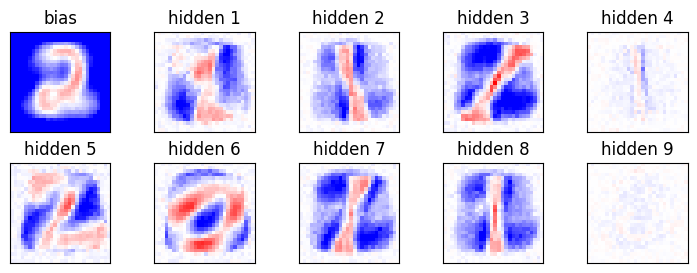

Epoch: 41 / 150
Epoch: 42 / 150
Epoch: 43 / 150
Epoch: 44 / 150
Epoch: 45 / 150
Epoch: 46 / 150
Epoch: 47 / 150
Epoch: 48 / 150
Epoch: 49 / 150
Epoch: 50 / 150
Epoch: 51 / 150
Epoch: 52 / 150
Epoch: 53 / 150
Epoch: 54 / 150
Epoch: 55 / 150
Epoch: 56 / 150
Epoch: 57 / 150
Epoch: 58 / 150
Epoch: 59 / 150
Epoch: 60 / 150


<Figure size 640x480 with 0 Axes>

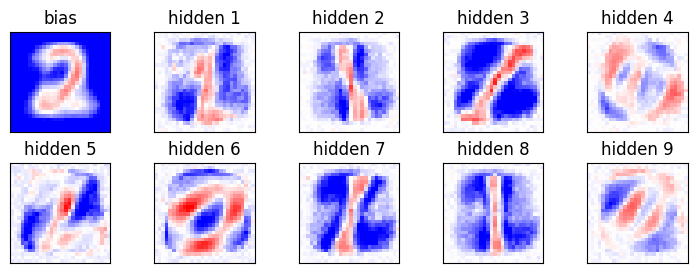

Epoch: 61 / 150
Epoch: 62 / 150
Epoch: 63 / 150
Epoch: 64 / 150
Epoch: 65 / 150
Epoch: 66 / 150
Epoch: 67 / 150
Epoch: 68 / 150
Epoch: 69 / 150
Epoch: 70 / 150
Epoch: 71 / 150
Epoch: 72 / 150
Epoch: 73 / 150
Epoch: 74 / 150
Epoch: 75 / 150
Epoch: 76 / 150
Epoch: 77 / 150
Epoch: 78 / 150
Epoch: 79 / 150
Epoch: 80 / 150


<Figure size 640x480 with 0 Axes>

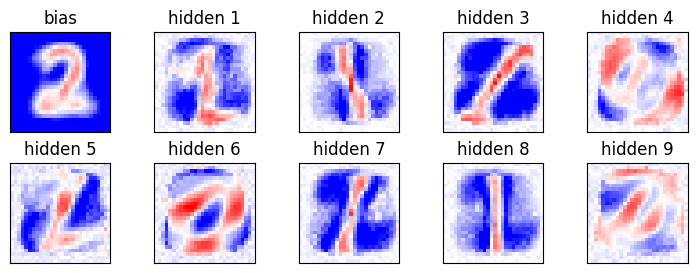

Epoch: 81 / 150
Epoch: 82 / 150
Epoch: 83 / 150
Epoch: 84 / 150
Epoch: 85 / 150
Epoch: 86 / 150
Epoch: 87 / 150
Epoch: 88 / 150
Epoch: 89 / 150
Epoch: 90 / 150
Epoch: 91 / 150
Epoch: 92 / 150
Epoch: 93 / 150
Epoch: 94 / 150
Epoch: 95 / 150
Epoch: 96 / 150
Epoch: 97 / 150
Epoch: 98 / 150
Epoch: 99 / 150
Epoch: 100 / 150


<Figure size 640x480 with 0 Axes>

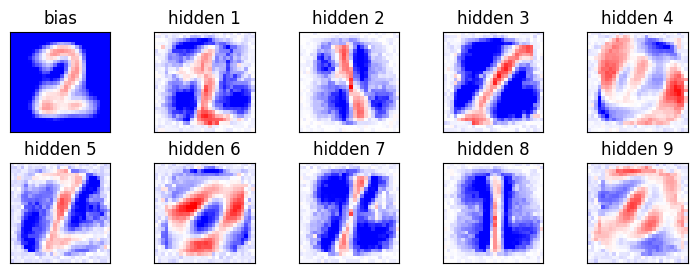

Epoch: 101 / 150
Epoch: 102 / 150
Epoch: 103 / 150
Epoch: 104 / 150
Epoch: 105 / 150
Epoch: 106 / 150
Epoch: 107 / 150
Epoch: 108 / 150
Epoch: 109 / 150
Epoch: 110 / 150
Epoch: 111 / 150
Epoch: 112 / 150
Epoch: 113 / 150
Epoch: 114 / 150
Epoch: 115 / 150
Epoch: 116 / 150
Epoch: 117 / 150
Epoch: 118 / 150
Epoch: 119 / 150
Epoch: 120 / 150


<Figure size 640x480 with 0 Axes>

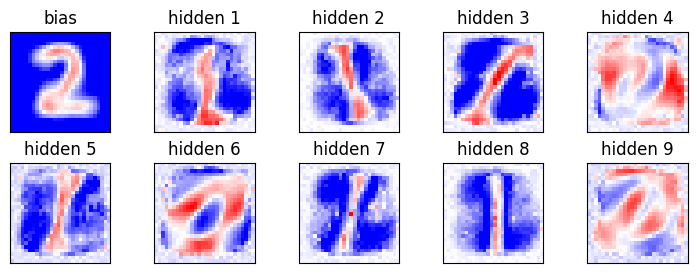

Epoch: 121 / 150
Epoch: 122 / 150
Epoch: 123 / 150
Epoch: 124 / 150
Epoch: 125 / 150
Epoch: 126 / 150
Epoch: 127 / 150
Epoch: 128 / 150
Epoch: 129 / 150
Epoch: 130 / 150
Epoch: 131 / 150
Epoch: 132 / 150
Epoch: 133 / 150
Epoch: 134 / 150
Epoch: 135 / 150
Epoch: 136 / 150
Epoch: 137 / 150
Epoch: 138 / 150
Epoch: 139 / 150
Epoch: 140 / 150


<Figure size 640x480 with 0 Axes>

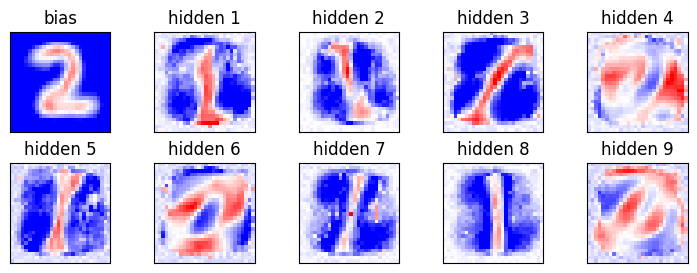

Epoch: 141 / 150
Epoch: 142 / 150
Epoch: 143 / 150
Epoch: 144 / 150
Epoch: 145 / 150
Epoch: 146 / 150
Epoch: 147 / 150
Epoch: 148 / 150
Epoch: 149 / 150
Epoch: 150 / 150
Spins


/tmp/ipykernel_11627/1976484515.py:87: RuntimeWarning: overflow encountered in exp
  exp_H_x   = np.exp(self.H_z_matrix @ x)  # Shape (2^L,)


POTTS


KeyboardInterrupt: 

In [48]:
L = 10
epochs = 150
n_likelihoods = 6
lr = 1e-1
epsilon = 1e-8
gamma = 1e-4

# RMSprop
print("Bernoulli")
rbm_bern = RBM(X_keep, L)
rbm_bern.initialize_params()
rbm_bern.training(epochs=epochs, optimizer="RMSprop", epsilon=epsilon, gamma=gamma, details=True)
rbm_bern.likelihood_history(n_likelihoods)

print("Spins")
rbm_spin = RBM(X_keep, L, spins=True)
rbm_spin.initialize_params()
rbm_spin.training(epochs=epochs, optimizer="RMSprop", epsilon=epsilon, gamma=gamma, details=True)
rbm_spin.likelihood_history(n_likelihoods)

print("POTTS")
rbm_potts = RBM(X_keep, L, potts=True)
rbm_potts.initialize_params()
rbm_potts.training(epochs=epochs, optimizer="RMSprop", epsilon=epsilon, gamma=gamma, details=True)
rbm_potts.likelihood_history(n_likelihoods)

In [ ]:
list_e = rbm_bern.log_likelihood.esit_ix
list_l_bern = rbm_bern.log_likelihood.esit
list_l_spin = rbm_spin.log_likelihood.esit
list_l_potts = rbm_potts.log_likelihood.esit

plt.plot(list_e, list_l_bern, "o-", label="Bernoulli")
plt.plot(list_e, list_l_spin, "o-", label="Spins")
plt.plot(list_e, list_l_potts, "o-", label="POTTS")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log-likelihood")
plt.show()

In [ ]:
L = 10
epochs = 150
n_likelihoods = 6
gamma = 1e-4

# SGD
print("Bernoulli")
rbm_bern = RBM(X_keep, L)
rbm_bern.initialize_params()
rbm_bern.training(epochs=epochs, optimizer="SGD", gamma=gamma, details=True)
rbm_bern.likelihood_history(n_likelihoods)

print("Spins")
rbm_spin = RBM(X_keep, L, spins=True)
rbm_spin.initialize_params()
rbm_spin.training(epochs=epochs, optimizer="SGD", gamma=gamma, details=True)
rbm_spin.likelihood_history(n_likelihoods)

print("POTTS")
rbm_potts = RBM(X_keep, L, potts=True)
rbm_potts.initialize_params()
rbm_potts.training(epochs=epochs, optimizer="SGD", gamma=gamma, details=True)
rbm_potts.likelihood_history(n_likelihoods)

In [ ]:
list_e = rbm_bern.log_likelihood.esit_ix
list_l_bern = rbm_bern.log_likelihood.esit
list_l_spin = rbm_spin.log_likelihood.esit
list_l_potts = rbm_potts.log_likelihood.esit

plt.plot(list_e, list_l_bern, "o-", label="Bernoulli")
plt.plot(list_e, list_l_spin, "o-", label="Spins")
plt.plot(list_e, list_l_potts, "o-", label="POTTS")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log-likelihood")
plt.show()

In [10]:
# RBM initialization
rbm = RBM(X_keep, 6, spins=False, potts=False)
rbm.initialize_params()
rbm.training(epochs=20, optimizer="RMSprop")
rbm.likelihood_history(5)

Epoch: 1 / 20
Epoch: 2 / 20
Epoch: 3 / 20
Epoch: 4 / 20
Epoch: 5 / 20
Epoch: 6 / 20
Epoch: 7 / 20
Epoch: 8 / 20
Epoch: 9 / 20
Epoch: 10 / 20
Epoch: 11 / 20
Epoch: 12 / 20
Epoch: 13 / 20
Epoch: 14 / 20
Epoch: 15 / 20
Epoch: 16 / 20
Epoch: 17 / 20
Epoch: 18 / 20
Epoch: 19 / 20
Epoch: 20 / 20


In [11]:
print(rbm.log_likelihood.esit)

[-203.08152875476893, -187.16413973419816, -186.09391778733374, -177.36419891382897, -180.00459879256502]


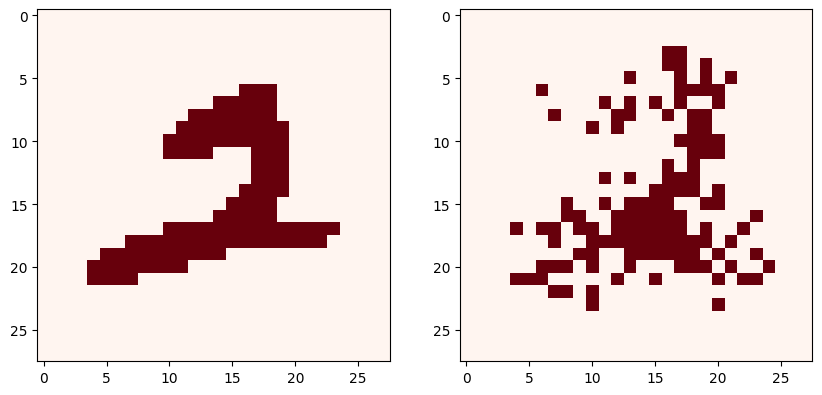

In [12]:
cmap = "Reds"
ix = np.random.choice(len(X_keep))
x_test = binarize_data(X_keep[ix])
v, _ = rbm.test(x_test)

fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(binarize_data(X_keep[ix], 0, 1).reshape((28,28)), cmap=cmap)
axes[1].imshow(v[-1].reshape((28,28)), cmap=cmap)
plt.show()

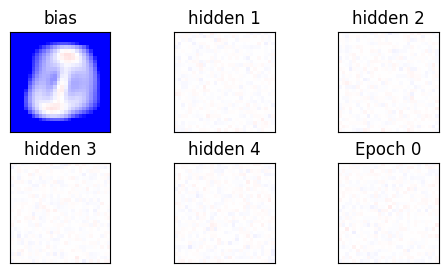

In [13]:
rbm.weights_bias_evolution(cols=rbm.L//2)

## Bernoulli

In [14]:
rbm = RBM(X_keep, 3, spins=True, potts=False)
rbm.initialize_params()
rbm.training(epochs=20, optimizer="SGD")

Epoch: 1 / 20
Epoch: 2 / 20
Epoch: 3 / 20
Epoch: 4 / 20
Epoch: 5 / 20
Epoch: 6 / 20
Epoch: 7 / 20
Epoch: 8 / 20
Epoch: 9 / 20
Epoch: 10 / 20
Epoch: 11 / 20
Epoch: 12 / 20
Epoch: 13 / 20
Epoch: 14 / 20
Epoch: 15 / 20
Epoch: 16 / 20
Epoch: 17 / 20
Epoch: 18 / 20
Epoch: 19 / 20
Epoch: 20 / 20


In [15]:
rbm.likelihood_history(5)
print(rbm.log_likelihood.esit)

/tmp/ipykernel_11627/2613220612.py:87: RuntimeWarning: overflow encountered in exp
  exp_H_x   = np.exp(self.H_z_matrix @ x)  # Shape (2^L,)


[inf, inf, inf, inf, inf]


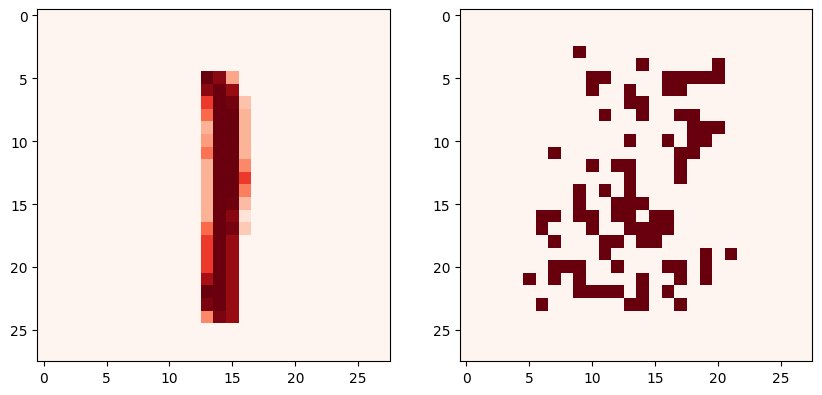

In [16]:
cmap = "Reds"
ix = np.random.choice(len(X_keep))
x_test = binarize_data(X_keep[ix], -1)
v, _ = rbm.test(x_test)

fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(X_keep[ix].reshape((28,28)), cmap=cmap)
axes[1].imshow(v[-1].reshape((28,28)), cmap=cmap)
plt.show()

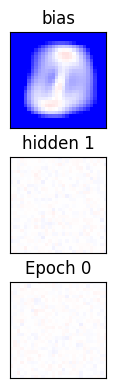

In [17]:
rbm.weights_bias_evolution(cols=rbm.L//2)

## POTTS = True

Epoch: 1 / 120
Epoch: 2 / 120
Epoch: 3 / 120
Epoch: 4 / 120
Epoch: 5 / 120
Epoch: 6 / 120
Epoch: 7 / 120
Epoch: 8 / 120
Epoch: 9 / 120
Epoch: 10 / 120
Epoch: 11 / 120
Epoch: 12 / 120
Epoch: 13 / 120
Epoch: 14 / 120
Epoch: 15 / 120
Epoch: 16 / 120
Epoch: 17 / 120
Epoch: 18 / 120
Epoch: 19 / 120
Epoch: 20 / 120


<Figure size 640x480 with 0 Axes>

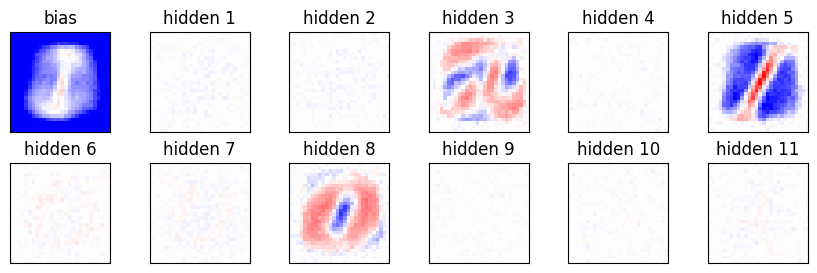

Epoch: 21 / 120
Epoch: 22 / 120
Epoch: 23 / 120
Epoch: 24 / 120
Epoch: 25 / 120
Epoch: 26 / 120
Epoch: 27 / 120
Epoch: 28 / 120
Epoch: 29 / 120
Epoch: 30 / 120
Epoch: 31 / 120
Epoch: 32 / 120
Epoch: 33 / 120
Epoch: 34 / 120
Epoch: 35 / 120
Epoch: 36 / 120
Epoch: 37 / 120
Epoch: 38 / 120
Epoch: 39 / 120
Epoch: 40 / 120


<Figure size 640x480 with 0 Axes>

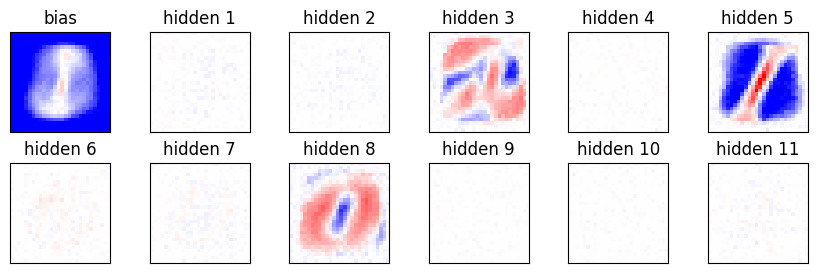

Epoch: 41 / 120
Epoch: 42 / 120
Epoch: 43 / 120
Epoch: 44 / 120
Epoch: 45 / 120
Epoch: 46 / 120
Epoch: 47 / 120
Epoch: 48 / 120
Epoch: 49 / 120
Epoch: 50 / 120
Epoch: 51 / 120
Epoch: 52 / 120
Epoch: 53 / 120
Epoch: 54 / 120
Epoch: 55 / 120
Epoch: 56 / 120
Epoch: 57 / 120
Epoch: 58 / 120
Epoch: 59 / 120
Epoch: 60 / 120


<Figure size 640x480 with 0 Axes>

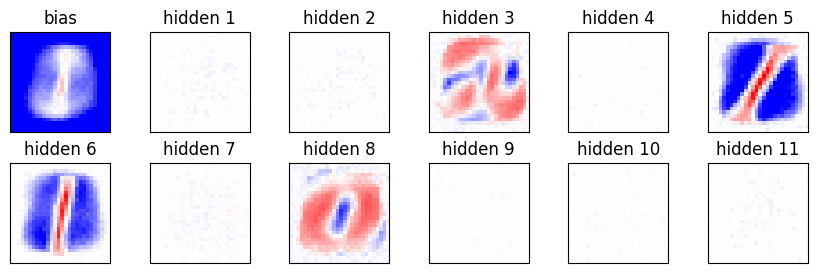

Epoch: 61 / 120
Epoch: 62 / 120
Epoch: 63 / 120
Epoch: 64 / 120
Epoch: 65 / 120
Epoch: 66 / 120
Epoch: 67 / 120
Epoch: 68 / 120
Epoch: 69 / 120
Epoch: 70 / 120
Epoch: 71 / 120
Epoch: 72 / 120
Epoch: 73 / 120
Epoch: 74 / 120
Epoch: 75 / 120
Epoch: 76 / 120
Epoch: 77 / 120
Epoch: 78 / 120
Epoch: 79 / 120
Epoch: 80 / 120


<Figure size 640x480 with 0 Axes>

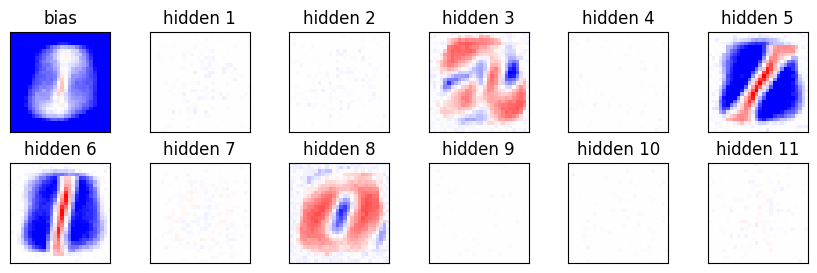

Epoch: 81 / 120
Epoch: 82 / 120
Epoch: 83 / 120
Epoch: 84 / 120
Epoch: 85 / 120
Epoch: 86 / 120
Epoch: 87 / 120
Epoch: 88 / 120
Epoch: 89 / 120
Epoch: 90 / 120
Epoch: 91 / 120
Epoch: 92 / 120
Epoch: 93 / 120
Epoch: 94 / 120
Epoch: 95 / 120
Epoch: 96 / 120
Epoch: 97 / 120
Epoch: 98 / 120
Epoch: 99 / 120
Epoch: 100 / 120


<Figure size 640x480 with 0 Axes>

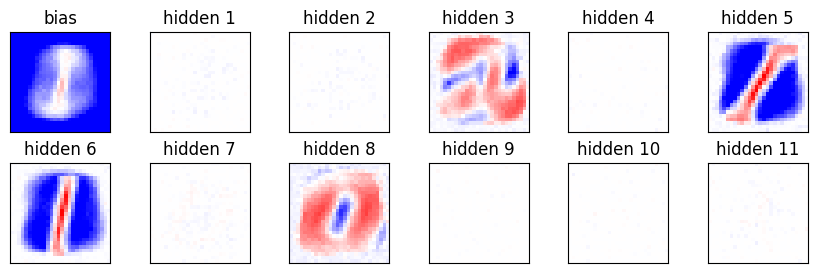

Epoch: 101 / 120
Epoch: 102 / 120
Epoch: 103 / 120
Epoch: 104 / 120
Epoch: 105 / 120
Epoch: 106 / 120
Epoch: 107 / 120
Epoch: 108 / 120
Epoch: 109 / 120
Epoch: 110 / 120
Epoch: 111 / 120
Epoch: 112 / 120
Epoch: 113 / 120
Epoch: 114 / 120
Epoch: 115 / 120
Epoch: 116 / 120
Epoch: 117 / 120
Epoch: 118 / 120
Epoch: 119 / 120
Epoch: 120 / 120


<Figure size 640x480 with 0 Axes>

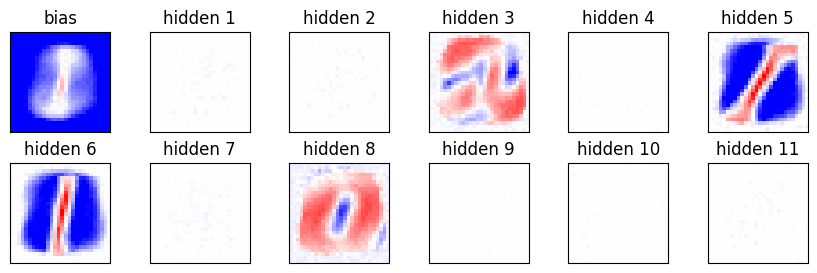

In [18]:
rbm = RBM(X_keep, 12, spins=False, potts=True)
rbm.initialize_params()
rbm.training(epochs=120, optimizer="RMSprop", details=True)

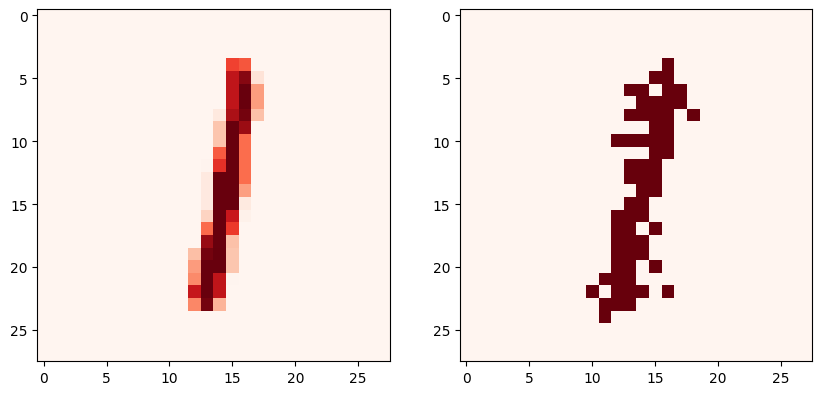

In [19]:
cmap = "Reds"
ix = np.random.choice(len(X_keep))
x_test = binarize_data(X_keep[ix])
v, _ = rbm.test(x_test)

fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(X_keep[ix].reshape((28,28)), cmap=cmap)
axes[1].imshow(v[-1].reshape((28,28)), cmap=cmap)
plt.show()

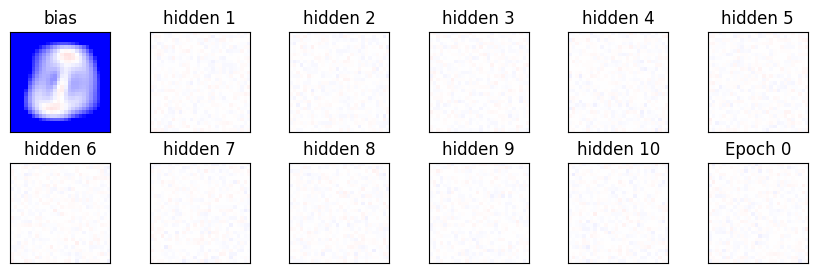

In [20]:
rbm.weights_bias_evolution(cols=rbm.L//2)

In [21]:
rbm.likelihood_history(5)

In [22]:
interval=200  
rows = int(np.ceil( rbm.L / cols))

fig, axes = plt.subplots(rows, cols, figsize=(s*(1+cols), s*rows))
plt.subplots_adjust(hspace=0.3)

images = []
for i in range(rows):
    row_images = []
    for j in range(cols):
        img = axes[i,j].imshow(np.zeros((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
        row_images.append(img)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
    images.append(row_images)

def animate(epoch):
    weights = rbm.params_history["w"][epoch]
    biases = rbm.params_history["a"][epoch]

    for i in range(rows):
        for j in range(cols):
            if i == j == 0:
                images[i][j].set_data(biases.reshape((28,28)))
                axes[i,j].set_title(f"bias")
            else:
                images[i][j].set_data(weights.T[i*cols+j-1].reshape((28,28)))
                axes[i,j].set_title(f"hidden {i*cols+j}")
    plt.title(f"Epoch {epoch}")
    return [img for row in images for img in row]

ani = FuncAnimation(fig, animate, repeat=True, frames=len(rbm.params_history["w"]), interval=interval)
HTML(ani.to_jshtml())

NameError: name 'cols' is not defined